# Utils for optimization

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io
import math
import sklearn
import sklearn.datasets

from opt_utils_v1a import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils_v1a import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset
from testCases import *

## 1 - Random mini batches

In [25]:
def random_minibatches(X,Y,mini_batch_size = 64,seed=10):
    '''Input: X,Y: dataset
              mini_batch_size: desired size of the batches
              seed: so each iteration is random
       Output: minibatches: list of mb_X,mb_Y minibatches '''
    
    m = X.shape[1]                  # number of training examples
    minibatches = []
    # Shuffle dataset
    perm = list(np.random.permutation(m))
    shuffled_X = X[:,perm]
    shuffled_Y = Y[:,perm].reshape((1,m))
    # Partition the dataset
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0,num_complete_minibatches):
        mb_X = shuffled_X[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mb_Y = shuffled_Y[:,k*mini_batch_size:(k+1)*mini_batch_size]
        minibatches.append((mb_X,mb_Y))
    # Last case
    if m/mini_batch_size != 0:
        mb_X = shuffled_X[:,num_complete_minibatches*mini_batch_size:]
        mb_Y = shuffled_Y[:,num_complete_minibatches*mini_batch_size:]
        minibatches.append((mb_X,mb_Y))
    return minibatches

## 2 - Gradient Descent

In [3]:
def update_parameters_with_gd(parameters,grads,lr):
    '''Input: parameters: original W and b
              grads: gradients for dW and db
              lr: learning rate
       Output: parameters: updated'''
    L = len(parameters) // 2
    for l in range(0,L):
        parameters['W'+str(l+1)] = parameters['W'+str(l+1)] - lr*grads['dW'+str(l+1)]
        parameters['b'+str(l+1)] = parameters['b'+str(l+1)] - lr*grads['db'+str(l+1)]
    return parameters

## 3 - Momentum

In [4]:
def initialize_velocity(parameters):
    '''Input: parameters: dictionary with W and b
       Output: v: dictionary with initialized velocities'''
    L = len(parameters) // 2
    v = {}
    for l in range(L):
        v['dW'+str(l+1)] = np.zeros(parameters['W'+str(l+1)].shape)
        v['db'+str(l+1)] = np.zeros(parameters['b'+str(l+1)].shape)
    return v

$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}\tag{3}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}\tag{4}$$

In [11]:
def update_parameters_with_momentum(parameters,grads,v,beta,lr):
    '''Input: parameters: original W and b
              grads: gradients for dW and db
              v: initialized velocities
              beta: momentum parameter
       Output: parameters: updated
               v: updated velocities'''
    L = len(parameters) // 2
    for l in range(L):
        v['dW'+str(l+1)] = beta*v['dW'+str(l+1)] + (1-beta)*parameters['W'+str(l+1)]
        v['db'+str(l+1)] = beta*v['db'+str(l+1)] + (1-beta)*parameters['b'+str(l+1)]
        parameters['W'+str(l+1)] = parameters['W'+str(l+1)]-lr*v['dW'+str(l+1)]
        parameters['b'+str(l+1)] = parameters['b'+str(l+1)]-lr*v['db'+str(l+1)]
    return parameters,v

## 4 - Adam 

## Model

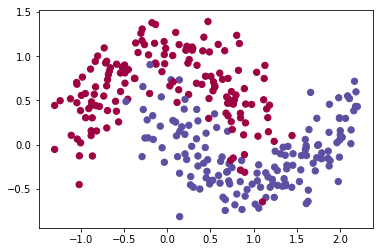

In [19]:
train_X,train_Y = load_dataset()

In [26]:
def model(X,Y,layers_dims,optimizer,lr=0.0007,mini_batch_size=64,beta=0.9,
         beta1=0.9,beta2=0.999,epsilon=1e-8,num_epochs=10000):
    '''Input: X,Y: input from moon dataset
              layers_dims: size of the layers of the NN
              optimizer: to choose between gradient descent, momentum or adam
            
        Output: parameters'''
    
    L = len(layers_dims)       # number of layers in the NN
    costs = []                 # keep track of costs
    seed = 10                  
    m = X.shape[1]             # number of training examples
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)
    if optimizer == 'gd':
        pass
    elif optimizer == 'momentum':
        v = initialize_velocity(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        seed = seed+1
        # Define random minibatches
        minibatches = random_minibatches(X,Y,mini_batch_size,seed)
        cost_total = 0
        
        for minibatch in minibatches:
            # Select a minibatch
            (mb_X,mb_Y) = minibatch
            # Forward propagation
            a,caches = forward_propagation(mb_X,parameters)
            # Compute cost
            cost_total += compute_cost(a,mb_Y)
            # Backward propagation
            grads = backward_propagation(mb_X,mb_Y,caches)
            # Update parameters
            if optimizer == 'gd':
                parameters = update_parameters_with_gd(parameters,grads,lr)
            elif optimizer == 'momentum':
                parameters = update_parameters_with_momentum(parameters,grads,v,beta,lr)
        cost_avg = cost_total / m
        costs.append(cost_avg)
        # Print cost evolution
        if i%1000 == 0:
            print("Cost after epoch %i: %f" %(i, cost_avg))
    # Plot cost evolution    
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs')
    plt.title('Learning rate = '+str(lr))
    plt.show()
            
    return parameters        

In [27]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

TypeError: tuple indices must be integers or slices, not str